# Evaluators

Coba Evaluators evaluate the performance of Learners in Environments. They have the following interface.

```python
class Evaluator:
    def evaluate(self, environment: Environment, learner: Learner) -> Iterable[dict]
        ...
```

Environments and Learners are described in more detail in [Environments.ipynb](Environments.ipynb) and [Learners.ipynb](Learners.ipynb). In this notebook we...

+ ...show how to create your own custom evaluators
+ ...describe the Evaluators provided by Coba out-of-the-box


# Custom Evaluator

Any class that conforms to the evaluator interface above can be used as an Evalutor in an Experiment. For example,

In [2]:
class MyEvaluator:
    def evaluate(self, environment, learner):
        yield {'a':1, 'b':2}
        yield {'a':2, 'b':3}

We can then pass our custom Evaluator to Experiment in order to generate results.

In [3]:
import coba as cb

env = cb.Environments.from_linear_synthetic(100)
lrn = cb.RandomLearner()
val = MyEvaluator()

result = cb.Experiment(env,lrn,val).run()

2024-02-02 14:37:33 -- Experiment Started
2024-02-02 14:37:33 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2024-02-02 14:37:33 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2024-02-02 14:37:33 -- Peeking at Environment 0... (0.0 seconds) (completed)
2024-02-02 14:37:33 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2024-02-02 14:37:33 -- Evaluating Learner 0 on Environment 0... (0.0 seconds) (completed)
2024-02-02 14:37:33 -- Experiment Finished


When we look at the result.evaluators we can see that MyEvaluator was used.

In [4]:
result.evaluators.to_pandas()

,evaluator_id,eval_type
0,0,MyEvaluator


We can also see that the return values from MyEvaluator were stored in result.interactions.

In [5]:
result.interactions.to_pandas()

,environment_id,learner_id,evaluator_id,index,a,b
0,0,0,0,1,1,2
1,0,0,0,2,2,3


We can even create a custom plot using the interactions produced by MyEvaluator.

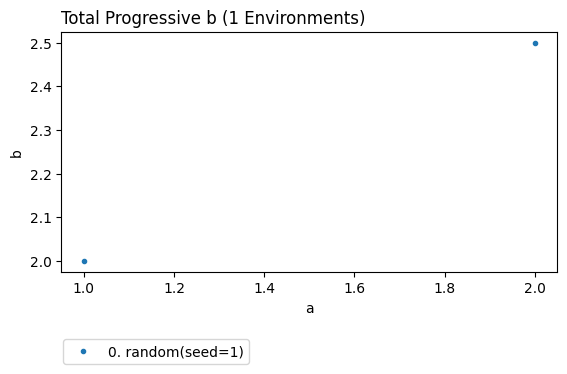

In [6]:
result.plot_learners(x='a',y='b')

If more than one Environment/Learner is passed to Experiment our custom Evalautor will be called for all combinations.

In [9]:
env = cb.Environments.from_linear_synthetic(100,seed=[1,2])
lrn = [cb.RandomLearner(seed=1),cb.RandomLearner(seed=2)]
val = MyEvaluator()
cb.Experiment(env,lrn,val).run(quiet=True).interactions.to_pandas()

,environment_id,learner_id,evaluator_id,index,a,b
0,0,0,0,1,1,2
1,0,0,0,2,2,3
2,0,1,0,1,1,2
3,0,1,0,2,2,3
4,1,0,0,1,1,2
5,1,0,0,2,2,3
6,1,1,0,1,1,2
7,1,1,0,2,2,3


To see how a custom Evaluator might work in practice we will now create an online learning Evaluator.

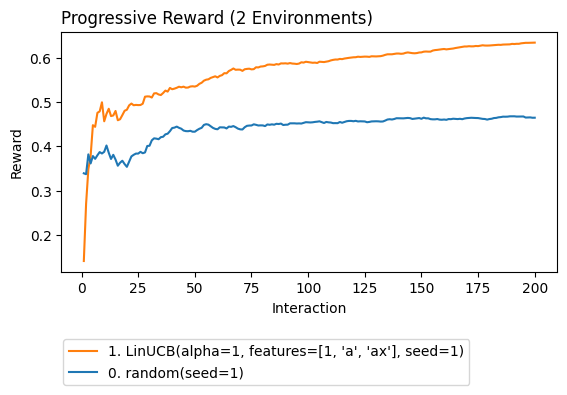

In [25]:
import coba as cb

class MyOnlineEvaluator:
    def evaluate(self, environment, learner):
        for interaction in environment.read():
            action,prob = learner.predict(interaction['context'],interaction['actions'])
            reward      = interaction['rewards'](action)
            learner.learn(interaction['context'],action,reward,prob)
            yield {'reward': reward }

env = cb.Environments.from_linear_synthetic(200,seed=[1,2])
lrn = [cb.RandomLearner(seed=1),cb.LinUCBLearner()]
val = MyOnlineEvaluator()

cb.Experiment(env,lrn,val).run(quiet=True).plot_learners()

# Built-in Evaluators
Coba comes with three built-in evaluators:
1. SequentialCB -- the default evaluator, it can perform on-policy and off-policy learning/evaluation for Learners
2. RejectionCB -- unbiased estimation of of exploration algorithm performance using logged interactions
3. SequentialIGL -- evaluation for interaction grounded learning algorithms with both feedback and rewards

### On-policy Evaluation without Learning

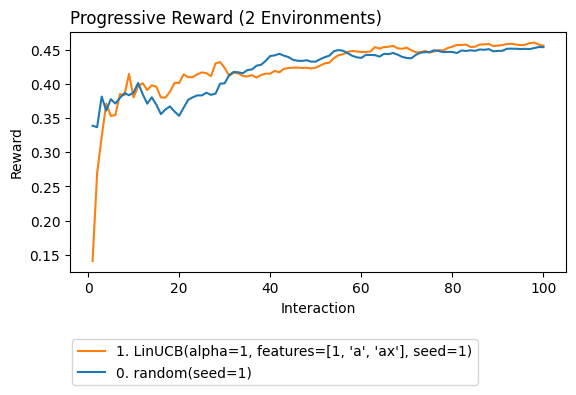

In [32]:
import coba as cb
env = cb.Environments.from_linear_synthetic(100,seed=[1,2])
lrn = [cb.RandomLearner(),cb.LinUCBLearner()]
val = cb.SequentialCB(learn=None)
cb.Experiment(env,lrn,val).run(quiet=True).plot_learners()

### On-policy Learning without Evaluation

In [46]:
import coba as cb
env = cb.Environments.from_linear_synthetic(200, n_context_features=0, n_action_features=2, seed=1)
lrn = cb.LinUCBLearner(features=[1,'a'])
val = cb.SequentialCB(eval=None)

print("No Theta has been learned")
print("#########################")
print(lrn._theta)

print()
cb.Experiment(env,lrn,val).run(quiet=True).plot_learners()

print()
print("#########################")
print("A Theta has been learned")
print("#########################")
print(lrn._theta)


No Theta has been learned
#########################
None

This result does not contain any data to plot.

#########################
A Theta has been learned
#########################
[ 0.47452277  0.48165662 -0.09730614]


### On-policy Learning from Reward Estimates

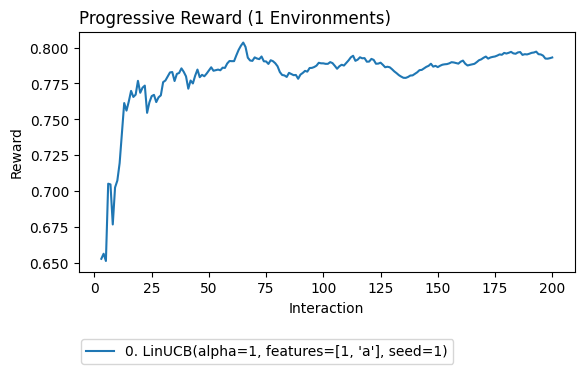

In [54]:
import coba as cb
env = cb.Environments.from_linear_synthetic(200, n_context_features=0, n_action_features=2, seed=1).logged(cb.RandomLearner())
lrn = cb.LinUCBLearner(features=[1,'a'])
val = cb.SequentialCB(learn='dm',eval='on')
cb.Experiment(env,lrn,val).run(quiet=True).plot_learners(xlim=(3,None))

### Off-policy Learning with On-Policy Evaluation

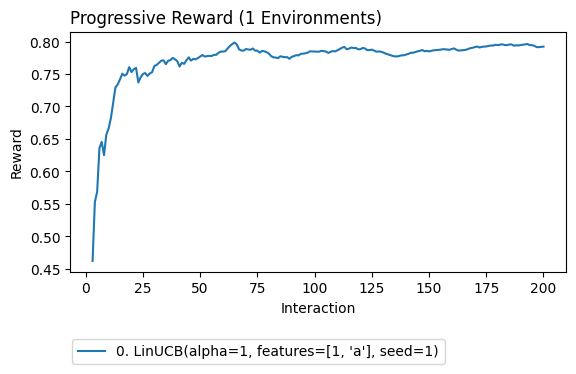

In [55]:
import coba as cb
env = cb.Environments.from_linear_synthetic(200, n_context_features=0, n_action_features=2, seed=1).logged(cb.RandomLearner())
lrn = cb.LinUCBLearner(features=[1,'a'])
val = cb.SequentialCB(learn='off',eval='on')
cb.Experiment(env,lrn,val).run(quiet=True).plot_learners(xlim=(3,None))

### Off-policy Learning with Off-Policy Evaluation

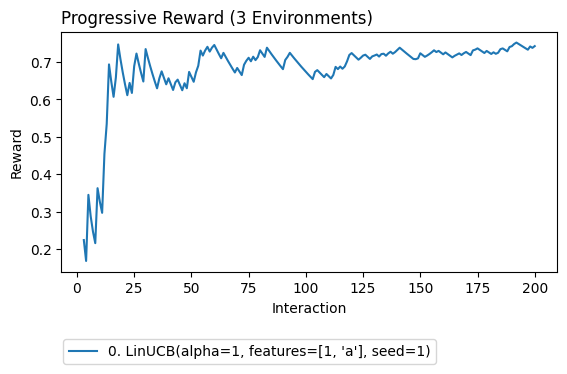

In [5]:
import coba as cb
env = cb.Environments.from_linear_synthetic(200, n_context_features=0, n_action_features=2, seed=[1,2,3]).logged(cb.RandomLearner())
lrn = cb.LinUCBLearner(features=[1,'a'])
val = cb.SequentialCB(learn='off',eval='ips')
cb.Experiment(env,lrn,val).run(quiet=True).plot_learners(xlim=(3,None))